In [1]:
import os 
import sys
import ast
import pandas as pd
import seaborn as sns
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import fbprophet as pro

%matplotlib inline

# 1. Importing data

## 1.1 Pageview and revisions

In [2]:
combined_data = pd.read_csv('../data/test15/cleaned/combined.csv')
combined_data.timestamp = pd.to_datetime(combined_data.timestamp)
# In the interest of memory I'm going to immeadiately subset the combined data
combined_data = combined_data[['timestamp', 'revid', 'page_title', 'character_count', 
                               'external_link_count', 'heading_count', 'page_views',
                               'wikifile_count', 'wikilink_count', 'word_count']]

In [3]:
combined_data.sort_values(by=['page_title', 'timestamp'], inplace=True)

In [4]:
combined_data.head()

,timestamp,revid,page_title,character_count,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
0,2015-07-01,NaN,'Amran,NaN,NaN,NaN,14.0,NaN,NaN,NaN
1,2015-07-02,NaN,'Amran,NaN,NaN,NaN,12.0,NaN,NaN,NaN
2,2015-07-03,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN
3,2015-07-04,NaN,'Amran,NaN,NaN,NaN,8.0,NaN,NaN,NaN
4,2015-07-05,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN


## 1.2 Category data

In [5]:
category_data = pd.read_csv('../data/test15/cleaned/category_data.csv')

In [6]:
category_data.head()

,Unnamed: 0,page_title,revid,categories
0,0,Aubre de Lambert Maynard,786130355.0,[]
1,1,Nabla,715468992.0,[]
2,2,President-elect of the United States,670644904.0,"['Titles', 'Elections in the United States']"
3,3,Space Oddity,672181778.0,"['1975 singles', 'Song recordings produced by ..."
4,4,Tillakaratne Dilshan,669932370.0,"['Sri Lankan Buddhists', 'People from Western ..."


## 1.3 Links pointing to pages

In [7]:
pointer_data = pd.read_csv('../data/test15/cleaned/pointers.csv')

In [8]:
pointer_data.head()

,Unnamed: 0,page_title,talk_link_count,wiki_link_count,wikipeida_count,user_count
0,0,Aubre de Lambert Maynard,0,2,0,0
1,1,Nabla,1,17,0,0
2,2,President-elect of the United States,56,327,0,0
3,3,Space Oddity,35,487,0,0
4,4,Tillakaratne Dilshan,32,535,0,0


# 2 Processing data

## 2.1 Selecting categories

In [9]:
category_dict = {}
# category_data.set_index('page_title', inplace=True)

for page_title, df in category_data.iterrows():
    # lists were converted to a single string parsing them with ast
    for category in ast.literal_eval(df['categories']):
        try:
            category_dict[category] += 1
        except:
            category_dict[category] = 1


In [10]:
category_df = pd.DataFrame.from_dict(category_dict, orient='index')

In [11]:
category_df = category_df.sort_values(by=0, ascending=False)

In [12]:
category_df.iloc[:25]

,0
Living people,957
Articles containing video clips,195
American people of Irish descent,101
American people of English descent,100
Grammy Award winners,99
21st-century American writers,79
Battles of World War I involving Germany,78
World Digital Library related,77
20th-century American writers,75
American people of German descent,73


In [13]:
# subsetting a selection of categories

list_of_categories = ['Living people', 'Grammy Award winners', 
                      '21st-century American writers', '20th-century American writers',
                      'Member states of the United Nations', 'American films',
                      'American political writers', 'Machine learning']

In [14]:
# Pulling out the page titles which have these pages

category_dict = {}
category_data.set_index('page_title', inplace=True)

for page, df in category_data.iterrows():
    for category in ast.literal_eval(df['categories']):
        if category in list_of_categories:
            try:
                category_dict[category].append(page)
            except:
                category_dict[category] = [page]

Categories on wikiedia are all over the place and it looks like supercategories don't exist. For example - there are many instances of battles in the above list (Battles of the Western Front (World War I), Battles of World War I involving France), but there is no "Battles" category.

It is possible that these will need to be futher clustered or it means that I will have to consider a different sampling technique to collectdata.

## 2.2 Reducing wikipedia edits to counts

Instead of knowing specific details of each edit it would be nice to know the number of edits that wikipedia page experinced in a single day

In [15]:
# Generating summary numbers for edits

combined_data.set_index('timestamp', inplace=True)
number_of_edits = combined_data[['revid', 'page_title']].groupby('page_title')['revid'].resample('1d').count()
number_of_edits = number_of_edits.to_frame(name='number_of_edits')

In [16]:
number_of_edits.reset_index(inplace=True)

number_of_edits.set_index(['page_title', 'timestamp'], inplace=True)

combined_data.reset_index(inplace=True)
combined_data.set_index(['page_title', 'timestamp'],inplace=True)

combined_data = pd.concat([combined_data, number_of_edits], sort=False)
combined_data = combined_data.sort_index(level=1).sort_index(level=0)

# Resampling to deal with difficulties in aligning data

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
combined_data = combined_data.groupby('page_title').resample('1d').mean()

In [17]:
# let's resample this data by years taking the average

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
resampled_data = combined_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 'word_count', 'number_of_edits']].groupby('page_title').resample('1d').mean()

resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp')
resampled_data = resampled_data.groupby('page_title').apply(lambda x: x.ffill())

# After filling the NA we can get a yearly average for our data

resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)

resampled_data = resampled_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 
                                 'word_count', 'number_of_edits']].groupby('page_title').resample('1y').mean()

resampled_data.reset_index(inplace=True)

## 2.3 Combining backlink data with edits and pageviews

Currently backlink data only exists for the most recent version of the website. As there are likely seasonal effects of a website we'll assume that a yearly average is representative of current activity. 

In [18]:
resampled_data.set_index('timestamp', inplace=True)

# We subset our data to only consider the current year
resampled_data = resampled_data.loc['2018-12-31']

pages = set(resampled_data.page_title) & set(pointer_data.page_title)

print('Number of pages before downselecting', len(set(resampled_data.page_title)))
print('Number of pages after downselecting', len(set(pages)))

resampled_data = resampled_data[resampled_data.page_title.isin(pages)]

# Subsetting the pointer data to only include shared pages

pointer_data = pointer_data[pointer_data.page_title.isin(pages)]
pointer_data.set_index('page_title', inplace=True)

resampled_data.reset_index(inplace=True)
resampled_data.set_index(['page_title'], inplace=True)

resampled_data['backlink_wikilink_count'] = pointer_data['wiki_link_count']
resampled_data['backlink_wikitalk_count'] = pointer_data['talk_link_count']

resampled_data = resampled_data.dropna()

Number of pages before downselecting 8722
Number of pages after downselecting 8722


## 2.4 Visualizing data and transforming as necessary

The majority of the metrics that are considered are unbounded and are therefore likely right skewed. Here we visualize this data to deterimine what parameters need to be rescaled. As all of these data are >= 0 if rescaling is necessary data >0 will be log10 transformed.

### 2.4.1 Pageviews

In [19]:
resampled_data = resampled_data[(resampled_data.page_views > 0) & 
                                (resampled_data.word_count > 0)]

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


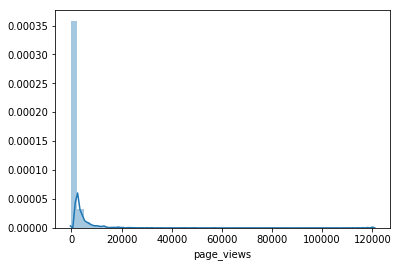

In [20]:
sns.distplot(resampled_data.page_views);

The page view data is clearly skewed - so we'll normalize this using a log 10 transform. 

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


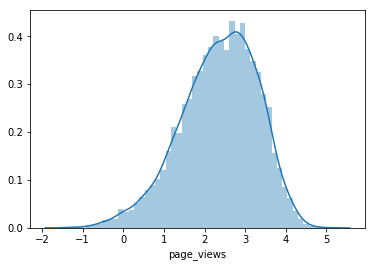

In [21]:
sns.distplot(np.log10(resampled_data.page_views));

In [22]:
# Saving this metric to our DF
resampled_data['log10_page_views'] = np.log10(resampled_data.page_views)

### 2.4.2 Word count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


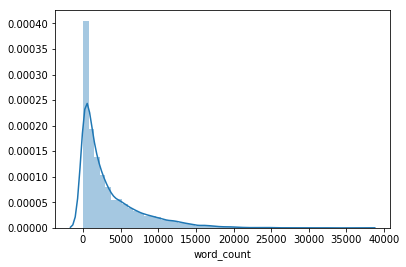

In [23]:
# Investigating word count

sns.distplot(resampled_data.word_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


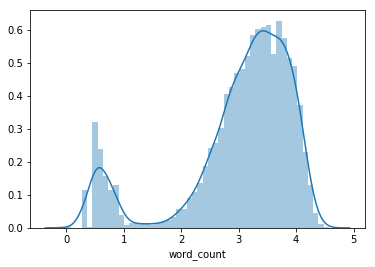

In [24]:
sns.distplot(np.log10(resampled_data.word_count))

Intersetingly this is bimodal ditribution.

In [25]:
resampled_data['log10_word_count'] = np.log10(resampled_data.word_count)

### 2.4.3 Wikilink count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


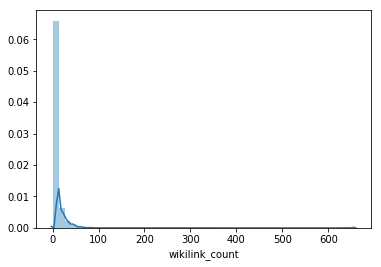

In [26]:
sns.distplot(resampled_data.wikilink_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


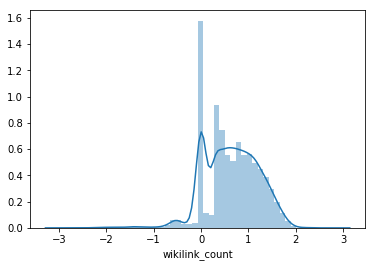

In [27]:
sns.distplot(np.log10(resampled_data[resampled_data.wikilink_count >0].wikilink_count))

In [28]:
resampled_data = resampled_data[resampled_data.wikilink_count >0]
resampled_data['log10_wikilink_count'] = np.log10(resampled_data.wikilink_count)

### 2.4.4 External link count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


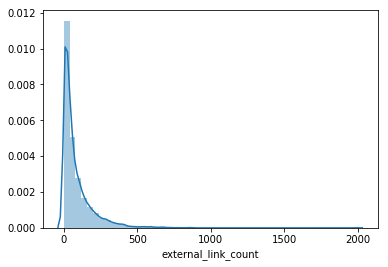

In [29]:
sns.distplot(resampled_data.external_link_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


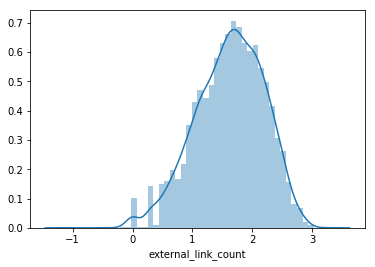

In [30]:
sns.distplot(np.log10(resampled_data[resampled_data.external_link_count >0].external_link_count))

In [31]:
resampled_data = resampled_data[resampled_data.external_link_count >0]
resampled_data['log10_external_link_count'] = np.log10(resampled_data.external_link_count)

### 2.4.5 Wikifile count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


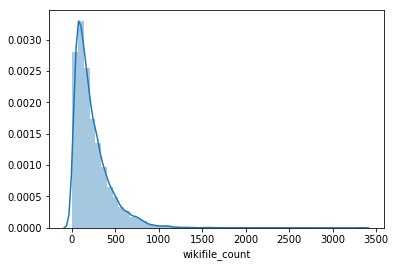

In [32]:
sns.distplot(resampled_data.wikifile_count)

In [33]:
resampled_data = resampled_data[resampled_data.wikifile_count >0]

resampled_data['log10_wikifile_count'] = np.log10(resampled_data.wikifile_count)

### 2.4.6 Backlink count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


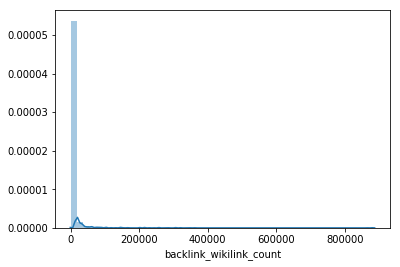

In [34]:
sns.distplot((resampled_data[resampled_data.backlink_wikilink_count >0].backlink_wikilink_count))

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


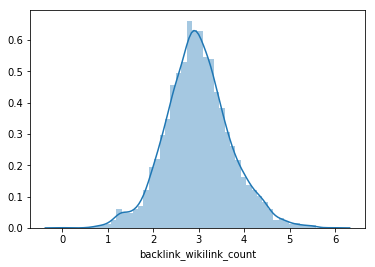

In [35]:
sns.distplot(np.log10(resampled_data[resampled_data.backlink_wikilink_count >0].backlink_wikilink_count))

In [36]:
resampled_data['log10_backlink_wikilink_count'] = np.log10(resampled_data.backlink_wikilink_count)

### 2.4.7 Heading count

In [37]:
(resampled_data.heading_count > 0).sum()

5385

In [38]:
len(resampled_data.heading_count)

5385

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


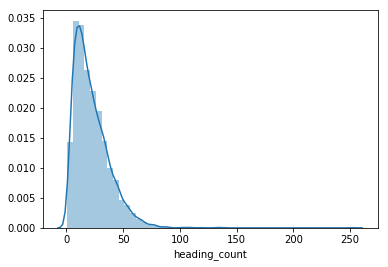

In [39]:
sns.distplot((resampled_data[resampled_data.heading_count >0].heading_count))

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


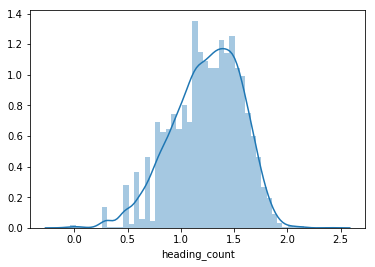

In [40]:
sns.distplot(np.log10(resampled_data[resampled_data.heading_count >0].heading_count))

In [41]:
resampled_data['log10_heading_count'] = np.log10(resampled_data.heading_count)

# 3 Analysis 

## 3.1 OLS Regression model 

Here an ordinary least squares regression model is used to predict pageviews



In [42]:
def ols_summary(df, X_columns, Y_column):
    """
    Input:  
        df - pandas dataframe of data
        X_columns - list of columns containing parameters
        Y_column - output column
    Returns: 
        The statistical results summary from the statsmodel package for OLS.
    """
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
#     X_top = X[feature_set]
#     X_norm_top = scale.fit_transform(X_top)

    X_norm_const = add_constant(df[X_columns])
    ols_model = OLS(df[Y_column], X_norm_const)
    ols_results = ols_model.fit()

    names = ['intercept']
    names.extend(list(X_columns))
    return ols_results.summary(xname=names)

In [79]:
X_columns = ['log10_wikifile_count', 'log10_external_link_count', 'log10_heading_count', 'log10_backlink_wikilink_count', 
            'log10_wikilink_count', 'log10_word_count']
y_column  = 'log10_page_views'

ols_summary(resampled_data, X_columns, y_column)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log10_page_views   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     479.6
Date:                Thu, 26 Jul 2018   Prob (F-statistic):               0.00
Time:                        09:47:49   Log-Likelihood:                -5528.4
No. Observations:                5385   AIC:                         1.107e+04
Df Residuals:                    5378   BIC:                         1.112e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                         0.2118      0.112      1.895      0.058      -0.007       0.431
log10_wikifile_count              0.4547      0.056      8.171      0.000       0.346       0.564
log10_external_link_count         0.3788      0.025     15.295      0.000       0.330       0.427
log10_heading_count              -0.2443      0.062     -3.913      0.000      -0.367      -0.122
log10_backlink_wikilink_count     0.3066      0.018     17.203      0.000       0.272       0.342
log10_wikilink_count             -0.0264      0.023     -1.167      0.243      -0.071       0.018
log10_word_count                  0.0842      0.054      1.556      0.120      -0.022       0.190
==============================================================================
Omnibus:                     2766.984   Durbin-Watson:                   0.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25582.169
Skew:                          -2.276   Prob(JB):                         0.00
Kurtosis:                      12.659   Cond. No.                         78.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The condition number of this analysis (78) implies that two or more of the predictors are colinear. This is not surprising as when an article gets longer (word count increases) it is more likely to have additional headings added, have more links added, and probably be referenced by other Wikipedia pages. 

## 3.2 Invesgiating co-linearity of parameters

### 3.2.1 Correlation

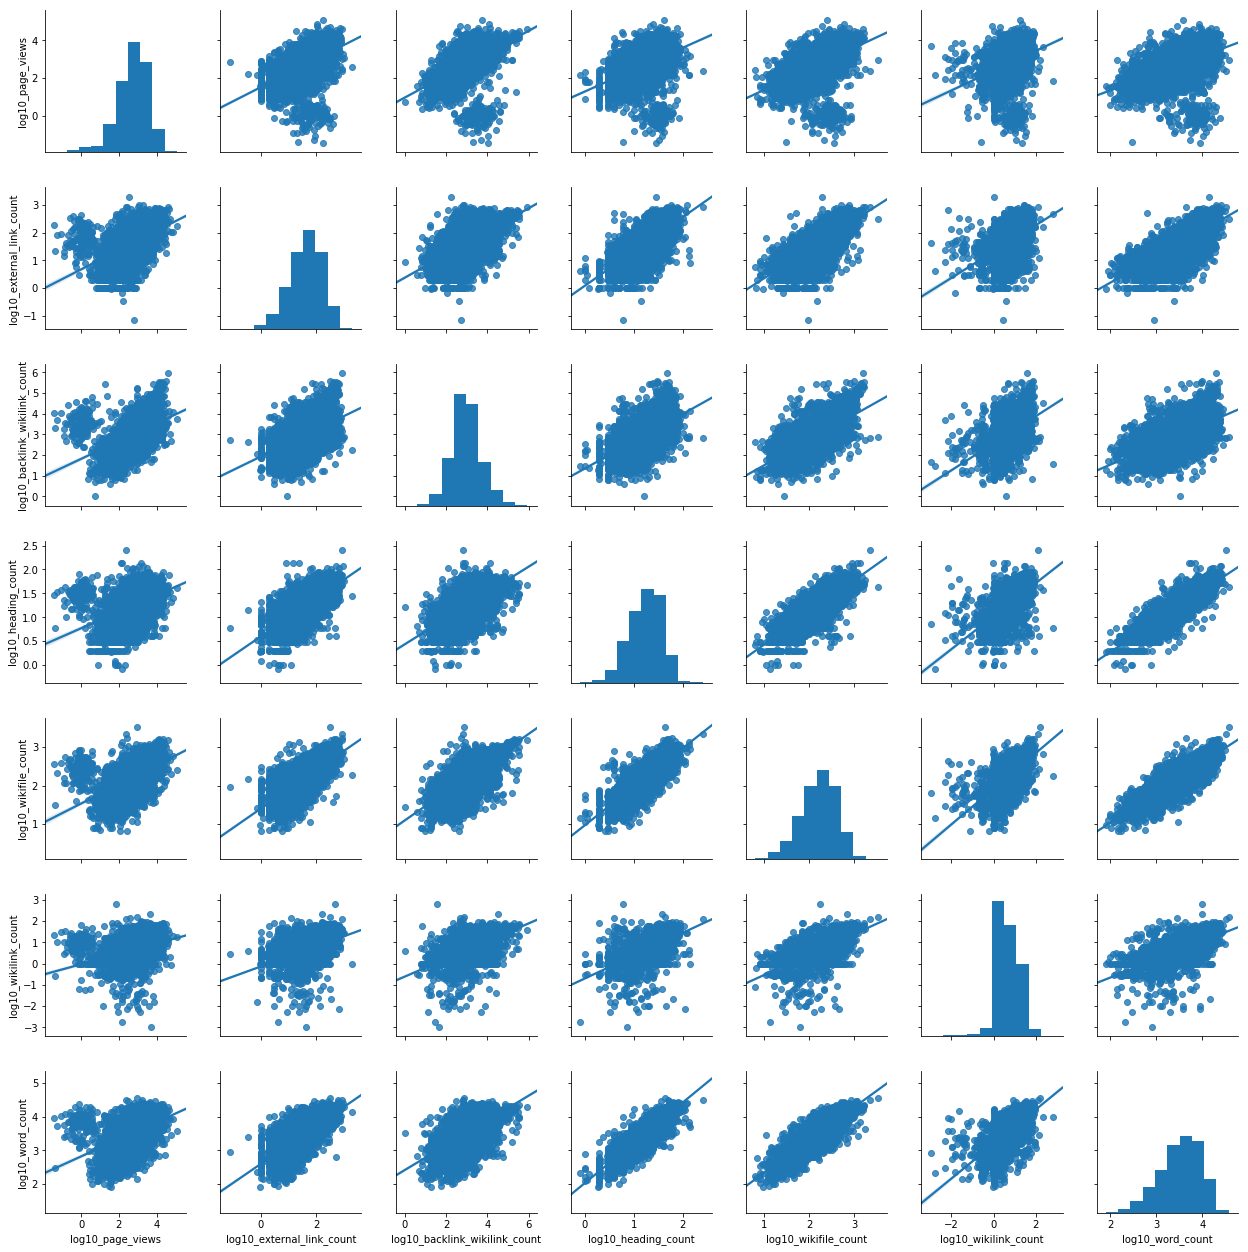

In [80]:
to_plot = ['log10_page_views', 'log10_external_link_count', 'log10_backlink_wikilink_count', 
             'log10_heading_count', 'log10_wikifile_count', 'log10_wikilink_count', 'log10_word_count']
sns.pairplot(resampled_data[to_plot], kind='reg')

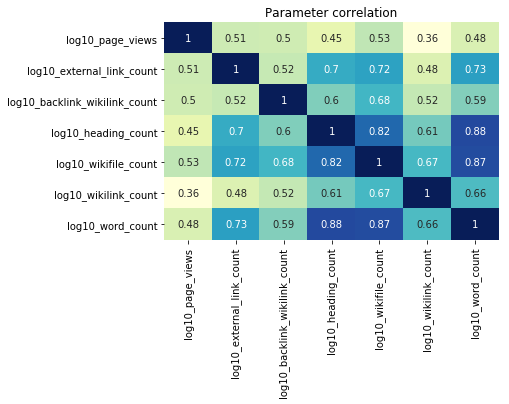

In [81]:
ax = sns.heatmap(resampled_data[to_plot].corr(), annot=True, cmap="YlGnBu", cbar=False)
ax.set_title('Parameter correlation');

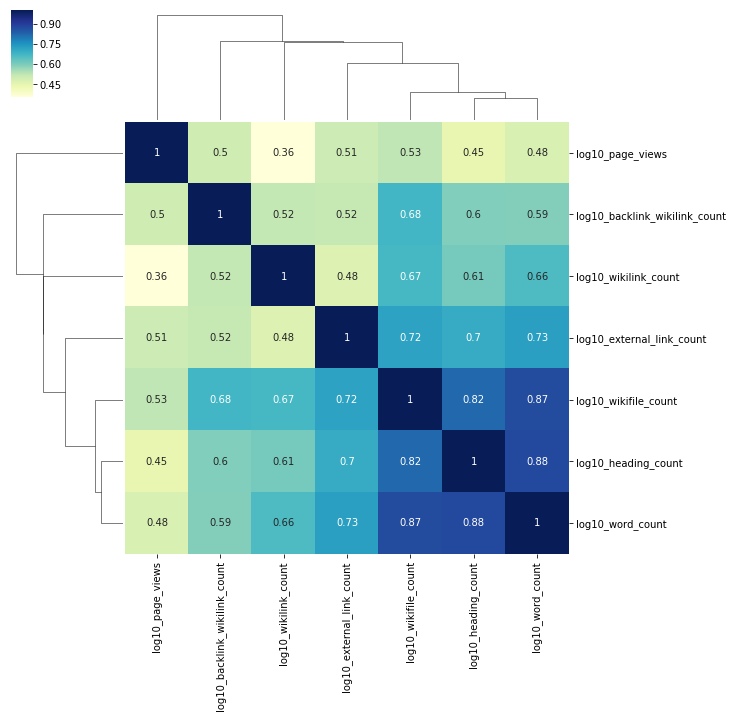

In [82]:
ax = sns.clustermap(resampled_data[to_plot].corr(), annot=True, cmap="YlGnBu")
# ax.set_title('Parameter correlation');

The least coorelated variable in this data set is page views, the parameter that is being predicted. The following parameters are highly correlated:

* word count 
* heading count 
* wikifile count 

If there is unqiue information in these features, for them to be included in a model would require feature engineering. 

### 3.2.2 Variance inflation factor (VIF)

Varience inflation factor generally estimates how the varience of the beta coefficent of a parameter is caused by co-linearity with other parameters. 

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

In [84]:
important_variables = ['log10_external_link_count', 'log10_backlink_wikilink_count', 
                       'log10_heading_count', 'log10_wikifile_count', 'log10_wikilink_count', 
                       'log10_word_count']

for index, name in enumerate(important_variables):
    print(name + ' VIF is: ',variance_inflation_factor(resampled_data[important_variables].values, index))

log10_external_link_count VIF is:  19.598026260606925
log10_backlink_wikilink_count VIF is:  34.30725654984244
log10_heading_count VIF is:  59.61236200743952
log10_wikifile_count VIF is:  184.1150425794247
log10_wikilink_count VIF is:  3.547969346470025
log10_word_count VIF is:  146.82302779847248


Interestingly only wikilink_count has a low VIF (<5). Each other paramter having a greater than 15 VIF implies lots of varience from colinearity.

### 3.2.2 Summary

As the ordinary least squares model has a high condition number (78), As each parameter has a high level of coorelation (>0.4) and each parameter has a large VIF. Here I will attempt to use a regularized fit to identify parameters which could be removed from the model.

## 3.3 Using regularization to identify less essential paremeters

In [85]:
def cross_val_parameters(X, y, estimator, cv=100, test_size=0.7):
    """
    This function will randomnly sample data from the population provided and refit it 
    using the provided estimator
    
    inputs:
    X: array of parameter data 
    y: array of output data
    estimator: sklearn.linear_model
    cv: number of times to sample data
    test_size: fraction of population to sample 
    
    outputs:
    array of intercept + beta parameter solutions
    
    """
    results = np.empty(shape=[cv, resampled_data[X_columns].shape[1] + 1])
    for count in range(cv):
        # Split the data
        X_test, X_train, y_test, y_train = model_selection.train_test_split(X, y, test_size=test_size)
        estimator.fit(X_test, y_test)
        results[count] = np.append(estimator.intercept_, estimator.coef_)
    return results

def plot_feature_importance(results, X_labels, label='', title=None):
    '''
    Input:  The feature importance or coefficient weights from a trained model.
    Return: A plot of the ordered weights, demonstrating relative importance of each feature.
    '''

    
    X_labels = ['intercept'] + X_labels
    df = pd.DataFrame(data=results, columns = X_labels)
    ax = sns.boxplot(data=df, orient='h')
    ax.set_title(title)
            
    return ax

### 3.3.1 Ridge regression

Ridge regression adds a penalty parameter to each beta term of a linear regression fit. This penality increases as the value of a beta term increases. The model then attempts to find the optimal beta terms given the training set and penalty. A consequence of this is that beta values that are uncertain (large confidence intervals, likely they could be zero, etc...) are dramatically reduced in size. 

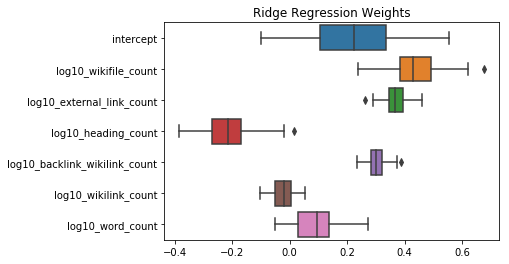

In [101]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.01, normalize=True)

results = cross_val_parameters(resampled_data[X_columns], resampled_data[y_column], ridge, cv=100)
plot_feature_importance(results, X_columns, title='Ridge Regression Weights')

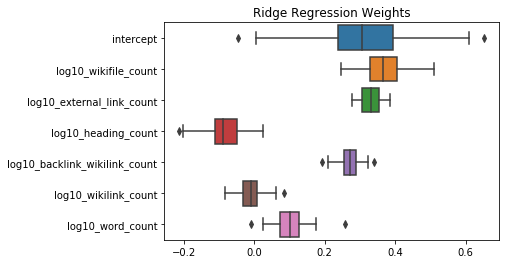

In [102]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1, normalize=True)

results = cross_val_parameters(resampled_data[X_columns], resampled_data[y_column], ridge, cv=100)
plot_feature_importance(results, X_columns, title='Ridge Regression Weights')

### 3.3.2 LASSO regression

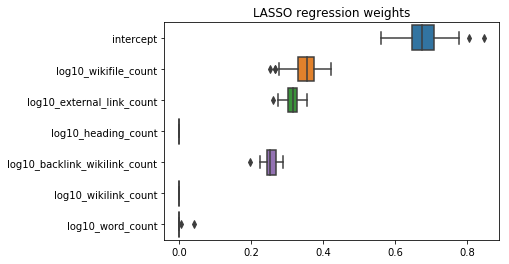

In [93]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001, normalize=True)

results = cross_val_parameters(resampled_data[X_columns], resampled_data[y_column], lasso, cv=50, test_size=0.5)
plot_feature_importance(results, X_columns, title='LASSO regression weights')

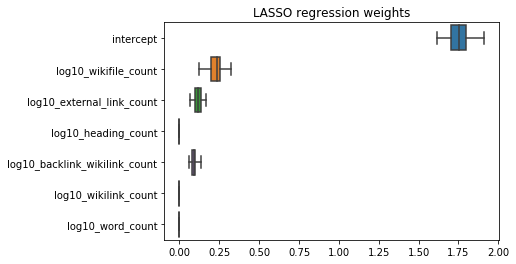

In [100]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.005, normalize=True)

results = cross_val_parameters(resampled_data[X_columns], resampled_data[y_column], lasso, cv=50, test_size=0.5)
plot_feature_importance(results, X_columns, title='LASSO regression weights')

### 3.3.3 Summary

Both methods of regularization identified that heading_count, wikilink_count and word_count would be diminished relative to wikifile_count, external_link_count, and backlink_count. 

Ideally we'd like to use more than just these parameters to model our data-set. So we'll be doing some feature engineering to attempt to account for colinearity.


## 3.4 Feature engineering